# Domain Adversarial calibration 域對抗校正

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import itertools
from dataPreprocess import read_dataset
from loss_functions import maximumMeanDiscrepancy
from sklearn.metrics import r2_score

In [2]:
sourceSessionIndex = 15
targetSessionIndex = 16

In [3]:
folderPath = './data'
fileList = sorted([i for i in os.listdir(folderPath) if i.endswith('.pkl.zip')])

In [4]:
sourceSession = fileList[sourceSessionIndex]
targetSession = fileList[targetSessionIndex]

In [5]:
sourceDataset = read_dataset(os.path.join(folderPath, sourceSession), ['velocity_x', 'velocity_y'])
targetDataset = read_dataset(os.path.join(folderPath, targetSession), ['velocity_x', 'velocity_y'])

In [6]:
TRAIN_COUNT = 5000

In [7]:
from model_tf import DomainAdversarialNetwork

model = DomainAdversarialNetwork()
model.compile(optimizer = 'adam', run_eagerly=True)

In [8]:
source_m1 = sourceDataset['m1']
target_m1 = targetDataset['m1']

source_movement = sourceDataset['movement']
target_movement = targetDataset['movement']

test_timestamp = targetDataset['timestamp'][TRAIN_COUNT:]

In [9]:
train_x_source = source_m1[:TRAIN_COUNT, -5:, :]
train_x_target = target_m1[:TRAIN_COUNT, -5:, :]
train_y_source_movement = source_movement[:TRAIN_COUNT]
train_y_target_movement = target_movement[:TRAIN_COUNT]
train_y_source_domain = np.zeros([5000])
train_y_target_domain = np.ones([5000])

train_y_source_domain = tf.one_hot(train_y_source_domain, 2) 
train_y_target_domain = tf.one_hot(train_y_target_domain, 2)

test_x = {
    'source': np.zeros_like(targetDataset['m1'][TRAIN_COUNT:, -5:, :]), 
    'target': targetDataset['m1'][TRAIN_COUNT:, -5:, :]
    }

test_y = target_movement[TRAIN_COUNT:]

In [10]:
train_x = {
    'source': train_x_source, 
    'target': train_x_target
    }
train_y = {
    'source_movement': train_y_source_movement, 
    'target_movement': train_y_target_movement, 
    'source_domain': train_y_source_domain, 
    'target_domain': train_y_target_domain
}

In [11]:
df = pd.DataFrame(columns=['x', 'y', 'label', 'epoch', 'mmd', 'velocity', 'session'])
# df.to_csv('./results/tSNE/domainAdaptationNetwork_feature.csv', index=False)

In [12]:
domain_losses = []
decode_losses = []

In [13]:
# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)

model.useTargetLabel = True
#
epochs = 105
for epoch in range(epochs):

    if epoch > 0:
        start_steps = epoch * len(train_dataset)
        total_steps = epochs * len(train_dataset)

        logs = []

        for step, (x, y) in enumerate(train_dataset):
        
            p = float(step + start_steps) / total_steps
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            model.alpha = alpha       
            log = model.train_on_batch(x=x, y=y, return_dict=True)
            logs.append(log)

        loog = pd.DataFrame(logs)
        decode_loss = loog.mean()['decode_loss']
        domain_loss = loog.mean()['domain_loss']
        print('epoch', epoch, 'decode_loss', decode_loss, 'domain_loss', domain_loss)
        decode_losses.append(decode_loss)
        domain_losses.append(domain_loss)
    
    # plot tSNE
    if epoch % 6 == 0:
        model.predict_movement = False        
        source_features, target_features = model.predict(x=train_x)

        model.predict_movement = True
        source_pred_y = model.predict(x={'source': np.zeros_like(train_x['target']), 'target': train_x['source']})
        target_pred_y = model.predict(x=train_x)

        mmd = [maximumMeanDiscrepancy(source=source_features[i:i+128], target=target_features[i:i+128]) \
            for i in range(0, source_features.shape[0], 128)]
        mmd = np.mean(mmd)
        
        tsne = TSNE(perplexity=50, n_components=2, init='random', n_iter=1000, random_state=5, verbose=0)
        transform = tsne.fit_transform(np.concatenate((source_features, target_features), axis=0))

        transform_source, transform_target = np.split(transform, [len(train_x['source'])], axis=0)

        df_source = pd.DataFrame({
            'x': transform_source[:, 0],
            'y': transform_source[:, 1],
            'label': 'source',
            'epoch': epoch,
            'mmd': mmd,
            'velocity': np.sqrt(train_y['source_movement'][:, 0]2 + train_y['source_movement'][:, 1]2),
            'session': sourceSessionIndex
        })

        df_target = pd.DataFrame({
            'x': transform_target[:, 0],
            'y': transform_target[:, 1],
            'label': 'target',
            'epoch': epoch,
            'mmd': mmd,
            'velocity': np.sqrt(train_y['target_movement'][:, 0]2 + train_y['target_movement'][:, 1]2),
            'session': targetSessionIndex
        })

        df = pd.concat((df, df_source, df_target), axis=0)

#         df = pd.concat((df, df_source, df_target), axis=0)
#         df.to_csv('./results/tSNE/domainAdaptationNetwork_feature.csv', index=False, header=False, mode='a')

epoch 1 decode_loss 35.895438766479494 domain_loss 0.42078849747776986
epoch 2 decode_loss 20.852743411064147 domain_loss 2.175551909953356
epoch 3 decode_loss 18.792852568626405 domain_loss 2.2858053483068943
epoch 4 decode_loss 16.94636266231537 domain_loss 0.7958816386759281
epoch 5 decode_loss 17.33453299999237 domain_loss 0.190149212628603
epoch 6 decode_loss 14.43300610780716 domain_loss 0.4625824376940727


In [14]:
df

,x,y,label,epoch,mmd,velocity,session
0,3.528817,-50.781906,source,6,1.006063,0.001632,15
1,3.441395,-50.863453,source,6,1.006063,0.001125,15
2,3.367446,-50.904667,source,6,1.006063,0.009670,15
3,3.250422,-50.951302,source,6,1.006063,0.006646,15
4,-30.325455,1.801669,source,6,1.006063,0.010461,15
...,...,...,...,...,...,...,...
4995,8.041392,-25.882935,target,6,1.006063,3.347533,16
4996,-19.122543,-36.842426,target,6,1.006063,2.752135,16
4997,-22.166447,-41.855747,target,6,1.006063,5.203055,16
4998,-22.158878,-49.749561,target,6,1.006063,5.887829,16


# 預測性能

In [15]:
model.predict_movement = True        
pred_y = model.predict(x=test_x)
r2_x = r2_score(y_pred = pred_y[:, 0], y_true = test_y[:, 0])
r2_y = r2_score(y_pred = pred_y[:, 1], y_true = test_y[:, 1])

In [16]:
'r2_x =', r2_x, 'r2_y =', r2_y

('r2_x =', 0.6648286035606923, 'r2_y =', 0.7455060780244191)

# 畫Loss圖

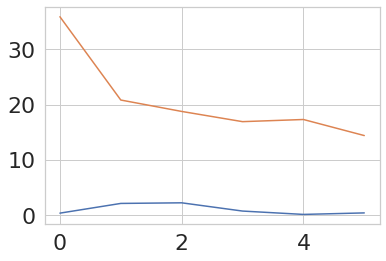

In [19]:
# loss
sns.set_theme(style='whitegrid', font_scale=2)

plt.plot(domain_losses)
plt.plot(decode_losses)

# Source & Target的 embedding 在訓練中的分布情形

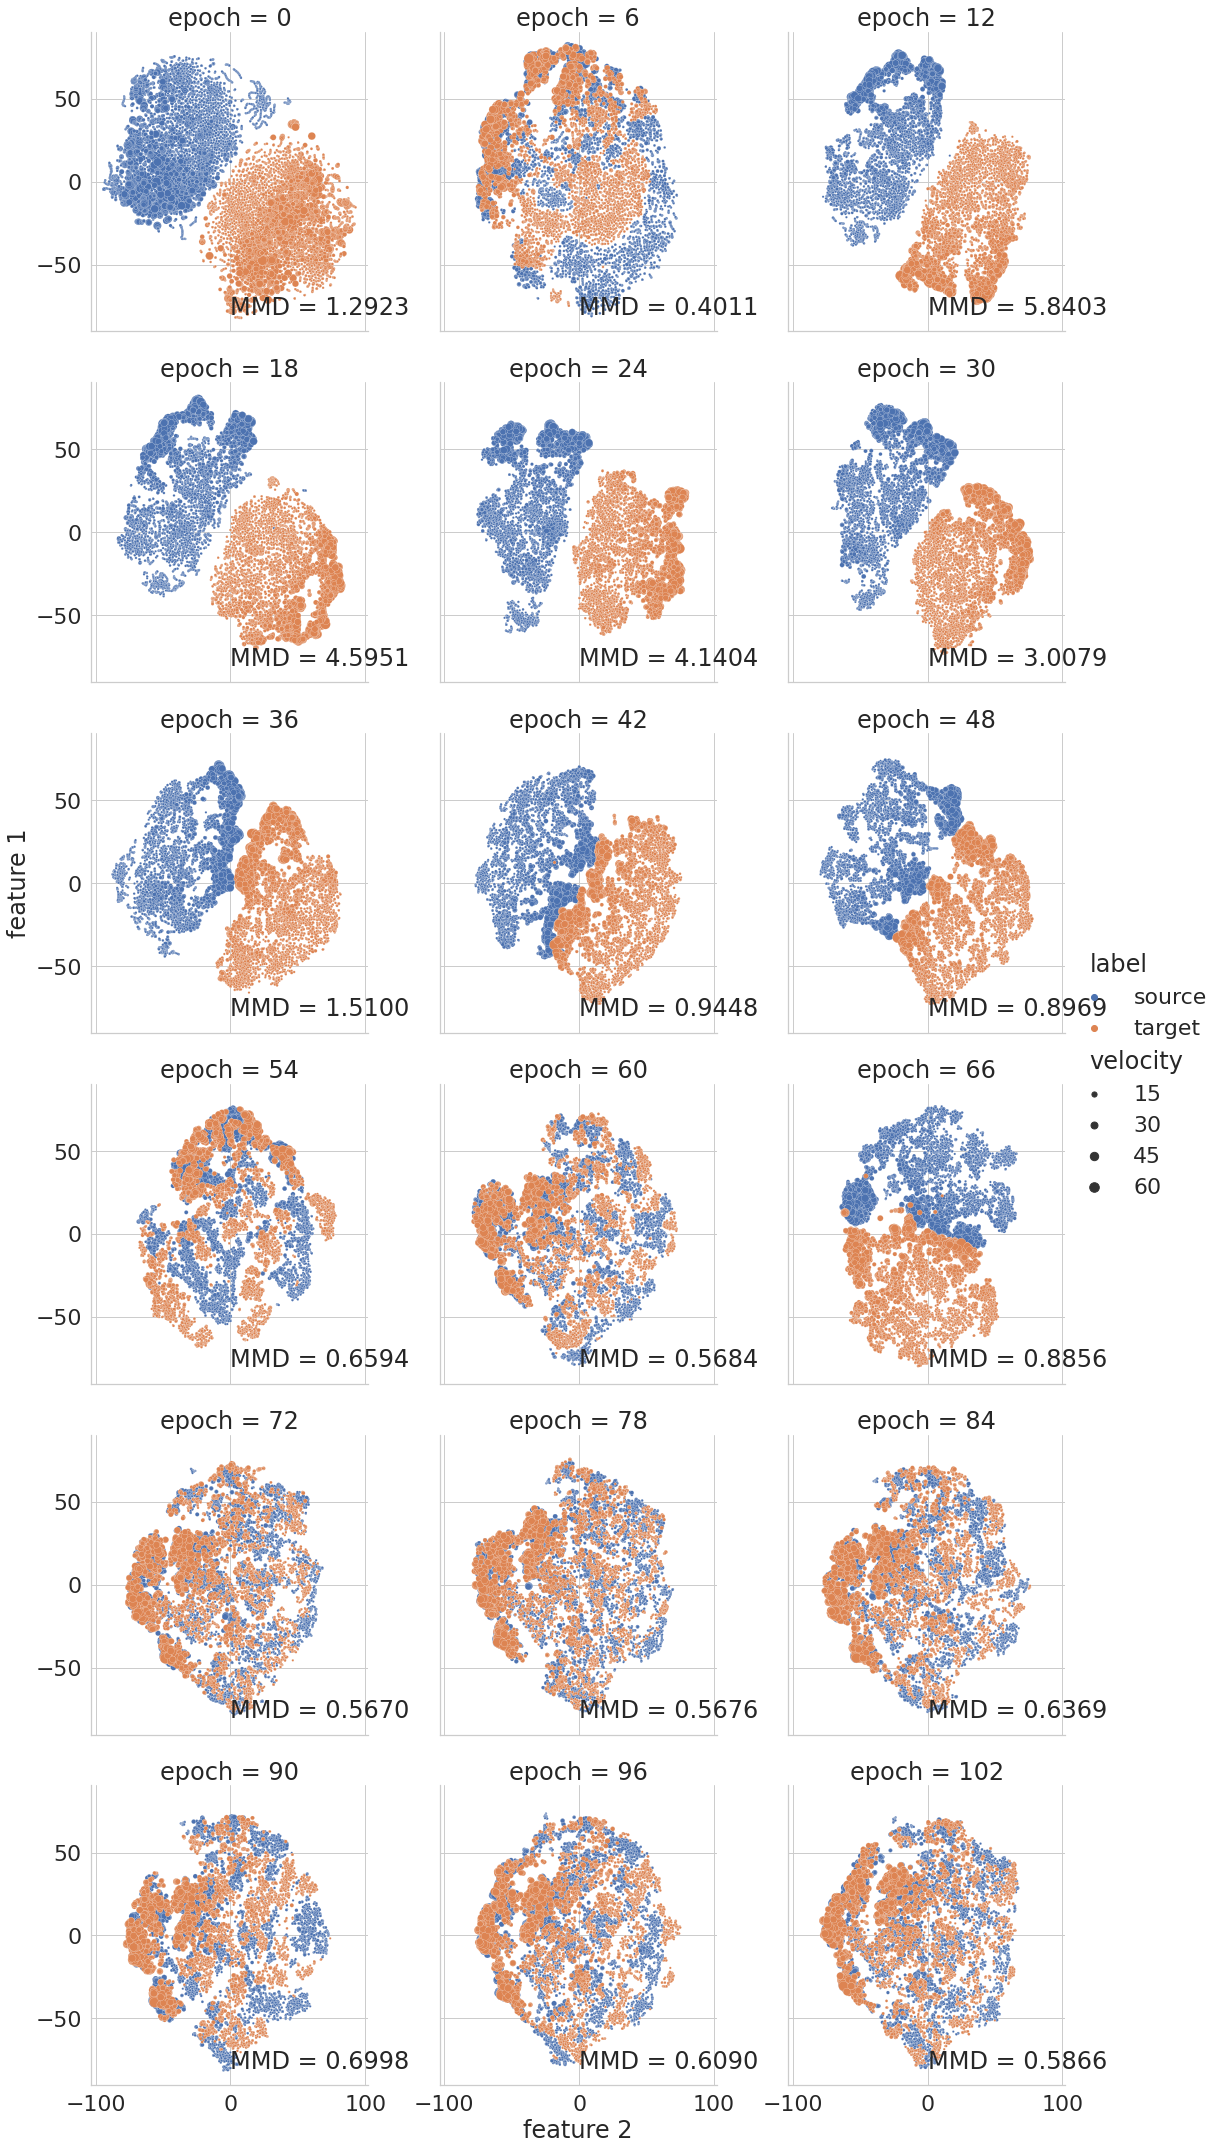

In [3]:
# DAN tSNE 速度大小
sns.set_theme(style='whitegrid', font_scale=2)

# df = pd.read_csv('./results/tSNE/domainAdaptationNetwork_feature.csv')
# df = df[(df['epoch'] <= 48)]
g = sns.relplot(kind='scatter', data=df, x='x', y='y', hue='label', col='epoch',\
    size='velocity', sizes=(5, 100), col_wrap=3, s=5)

g.set(xlabel='', ylabel='')
g.axes[6].set_ylabel('feature 1')
g.axes[16].set_xlabel('feature 2')

for ax, mmd in zip(g.axes.flat, df.groupby(['epoch']).mean()['mmd'].reset_index(drop=True)):
    ax.text(0, -80, f'MMD = {mmd:.4f}', fontsize=24)